# Homework 10: Image captioning with RNNs and LSTMs

# Image Captioning with RNNs

In this exercise, you will implement vanilla recurrent neural networks (RNNs), [long-short term memory networks (LSTMs)](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory), and [attention-based LSTMs](https://arxiv.org/abs/1409.0473) (HW11) to train a model that can generate natural language captions for images.

Models in this exercise are highly similar to very early works in neural-network based image captioning. If you are interested to learn more, check out these two papers:

1. [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/abs/1411.4555)
2. [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)

## Setup Code

Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You"ll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


 Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
["usefuns", "a5_helper.py", "rnn_lstm_captioning.ipynb",  "rnn_lstm_captioning.py", "Transformers.py", "Transformers.ipynb"]
```

In [3]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2021DL folder and put all the files under A0 folder, then '2021DL/A0'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/HW10' 
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['a5_helper.py', 'coco.pt', 'rnn_lstm_captioning.ipynb', 'usefuns', '__pycache__', 'rnn_lstm_captioning.py', 'hw10.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from rnn_lstm_captioning.py!
```

as well as the last edit time for the file `rnn_lstm_captioning.py`.

In [4]:
import os
import time
from rnn_lstm_captioning import hello_rnn_lstm_captioning


os.environ["TZ"] = "UTC"
time.tzset()
hello_rnn_lstm_captioning()

rnn_lstm_path = os.path.join(GOOGLE_DRIVE_PATH, "rnn_lstm_captioning.py")
rnn_lstm_edit_time = time.ctime(os.path.getmtime(rnn_lstm_path))
print("rnn_lstm_captioning.py last edited on %s" % rnn_lstm_edit_time)

Hello from rnn_lstm_captioning.py!
rnn_lstm_captioning.py last edited on Mon May  8 10:19:20 2023


### Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [5]:
import math
import os
import time

import matplotlib.pyplot as plt
import torch
from torch import nn

from usefuns.grad import compute_numeric_gradient, rel_error
from usefuns.utils import attention_visualizer, reset_seed

# for plotting
%matplotlib inline
plt.style.use("seaborn")  # Prettier plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 24
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

<ipython-input-5-45098d8bfff2>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")  # Prettier plots


We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [6]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")


# Define some common variables for dtypes/devices.
# These can be keyword arguments while defining new tensors.
to_float = {"dtype": torch.float32, "device": DEVICE}
to_double = {"dtype": torch.float64, "device": DEVICE}

Good to go!


# COCO Captions

For this exercise we will use the 2014 release of the [COCO Captions dataset](http://cocodataset.org/) which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

We have preprocessed the data for you already and saved them into a serialized data file. It contains 10,000 image-caption pairs for training and 500 for testing. The images have been downsampled to 112x112 for computation efficiency and captions are tokenized and numericalized, clamped to 15 words. You can download the file named `coco.pt` (378MB) with the link below and run some useful stats.

You will later use RegNet-X 400MF model to extract features for the images. A few notes on the caption preprocessing:

Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is saved in an entry named `vocab` (both `idx_to_token` and `token_to_idx`), and we use the function `decode_captions` from `a5_helper.py` to convert tensors of integer IDs back into strings.

There are a couple special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. Since they are a bit of a pain, we have taken care of all implementation details around special tokens for you.

In [7]:
import multiprocessing

# Set a few constants related to data loading.
IMAGE_SHAPE = (112, 112)
NUM_WORKERS = multiprocessing.cpu_count()

# Batch size used for full training runs:
BATCH_SIZE = 256

# Batch size used for overfitting sanity checks:
OVR_BATCH_SIZE = BATCH_SIZE // 8

# Batch size used for visualization:
VIS_BATCH_SIZE = 4

In [8]:
from a5_helper import load_coco_captions

# Download and load serialized COCO data from coco.pt
# It contains a dictionary of
# "train_images" - resized training images (IMAGE_SHAPE)
# "val_images" - resized validation images (IMAGE_SHAPE)
# "train_captions" - tokenized and numericalized training captions
# "val_captions" - tokenized and numericalized validation captions
# "vocab" - caption vocabulary, including "idx_to_token" and "token_to_idx"

# load COCO data from coco.pt, loaf_COCO is implemented in a5_helper.py
coco_path = os.path.join(GOOGLE_DRIVE_PATH, 'coco.pt') 
data_dict = load_coco_captions(path = coco_path)

num_train = data_dict["train_images"].size(0)
num_val = data_dict["val_images"].size(0)

# declare variables for special tokens
NULL_index = data_dict["vocab"]["token_to_idx"]["<NULL>"]
START_index = data_dict["vocab"]["token_to_idx"]["<START>"]
END_index = data_dict["vocab"]["token_to_idx"]["<END>"]
UNK_index = data_dict["vocab"]["token_to_idx"]["<UNK>"]

train_images <class 'torch.Tensor'> torch.Size([10000, 3, 112, 112]) torch.uint8
train_captions <class 'torch.Tensor'> torch.Size([10000, 17]) torch.int64
val_images <class 'torch.Tensor'> torch.Size([500, 3, 112, 112]) torch.uint8
val_captions <class 'torch.Tensor'> torch.Size([500, 17]) torch.int64
vocab <class 'dict'> dict_keys(['idx_to_token', 'token_to_idx'])

Train images shape:  torch.Size([10000, 3, 112, 112])
Train caption tokens shape:  torch.Size([10000, 17])
Validation images shape:  torch.Size([500, 3, 112, 112])
Validation caption tokens shape:  torch.Size([500, 17])
total number of caption tokens:  864
mappings (list) from index to caption token:  ['<NULL>', '<START>', '<END>', '<UNK>', 'a', 'on', 'of', 'the', 'in', 'with', 'and', 'is', 'man', 'to', 'sitting', 'two', 'an', 'standing', 'people', 'are', 'at', 'next', 'white', 'woman', 'table', 'that', 'street', 'holding', 'some', 'person', 'down', 'large', 'top', 'group', 'tennis', 'field', 'it', 'plate', 'up', 'small', 'r

## Look at the data
It is always a good idea to look at examples from the dataset before working with it.

Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

Note that we decode the captions using the `decode_captions` function.
You can check its implementation in `a5_helper.py`!

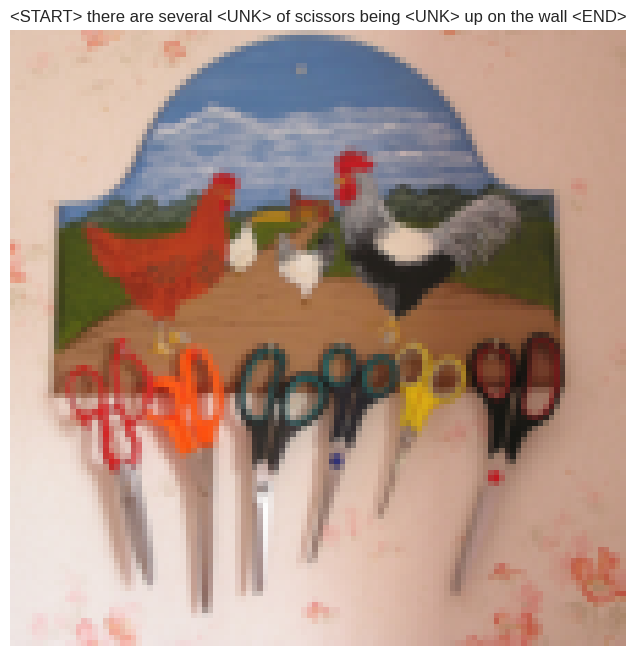

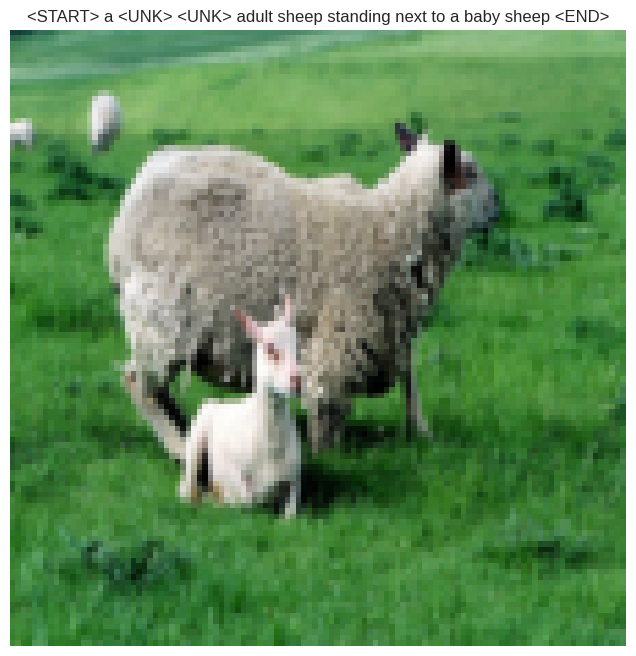

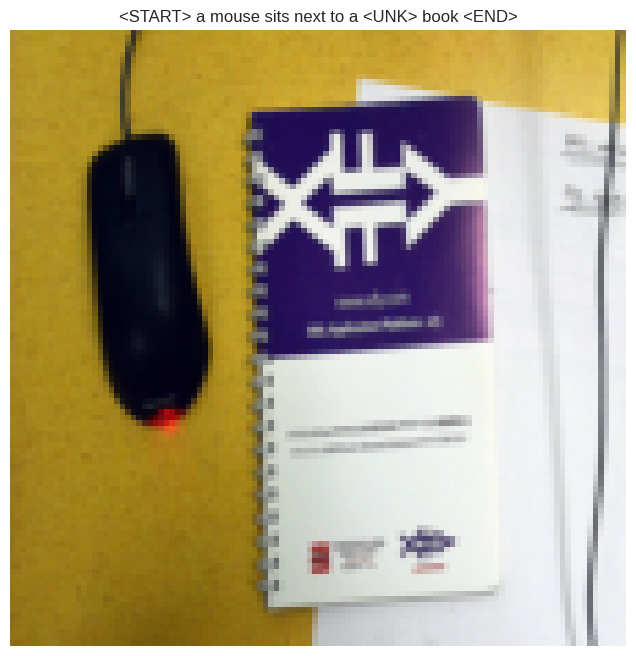

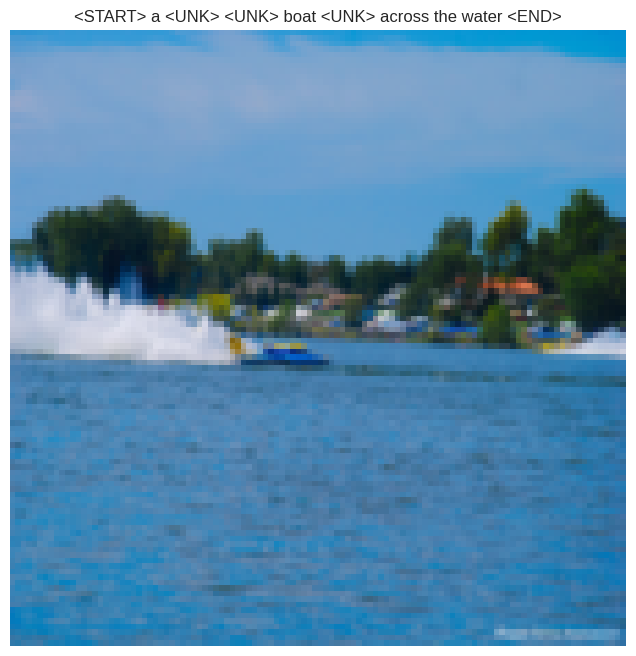

In [9]:
from a5_helper import decode_captions


# Sample a minibatch and show the reshaped 112x112 images and captions
sample_idx = torch.randint(0, num_train, (VIS_BATCH_SIZE, ))
sample_images = data_dict["train_images"][sample_idx]
sample_captions = data_dict["train_captions"][sample_idx]
for i in range(VIS_BATCH_SIZE):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis("off")
    caption_str = decode_captions(
        sample_captions[i], data_dict["vocab"]["idx_to_token"]
    )
    plt.title(caption_str)
    plt.show()

# Recurrent Neural Networks
As discussed in lecture, we will use Recurrent Neural Network (RNN) language models for image captioning. We will cover the vanilla RNN model first and later LSTM and attention-based language models.

# RNN for image captioning

You will implement a few necessary tools and layers in order to build an image captioning model (class `CaptioningRNN`).

## Image Feature Extraction

The first essential component in an image captioning model is an encoder that inputs an image and produces features for decoding the caption.
Here, we use a small [RegNetX-400MF](https://pytorch.org/vision/stable/models.html#torchvision.models.regnet_x_400mf) as the backbone so we can train in reasonable time on Colab. This model is similar to detector backbone seen in the past assignment.

It accepts image batches of shape `(B, C, H, W)` and outputs spatial features from final layer that have shape `(B, C, H/32, W/32)`.
For vanilla RNN and LSTM, we use the average pooled features (shape `(B, C)`) for decoding captions, whereas for attention LSTM we aggregate the spatial features by learning attention weights.
Checkout the `ImageEncoder` method in `rnn_lstm_captioning.py` to see the initialization of the model.

We use the implementation from torchvision and put a very thin wrapper module for our use-case.
You do not need to implement anything here — you should read and understand the module definition, available in `rnn_lstm_captioning.py`

In [10]:
from rnn_lstm_captioning import ImageEncoder

model = ImageEncoder(pretrained=True, verbose=True).to(device=DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_x_400mf-adf1edd5.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_400mf-adf1edd5.pth
100%|██████████| 21.3M/21.3M [00:00<00:00, 123MB/s] 


For input images in NCHW format, shape (2, 3, 224, 224)
Shape of output c5 features: torch.Size([2, 400, 7, 7])


## Word embedding
In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

Implement the `WordEmbedding` module to convert words (represented by integers) into vectors.
Run the following to check your implementation. You should see an error on the order of `1e-7` or less. 


In [11]:
from rnn_lstm_captioning import WordEmbedding

N, T, V, D = 2, 4, 5, 3

x = torch.tensor([[0, 3, 1, 2], [2, 1, 0, 3]]).long()
W = torch.linspace(0, 1, steps=V * D, **to_double).view(V, D)

# Copy custom weight vector for sanity check:
model_emb = WordEmbedding(V, D).to(**to_double)
model_emb.W_embed.data.copy_(W)
out = model_emb(x)
expected_out = torch.tensor(
    [
        [
            [0.0, 0.07142857, 0.14285714],
            [0.64285714, 0.71428571, 0.78571429],
            [0.21428571, 0.28571429, 0.35714286],
            [0.42857143, 0.5, 0.57142857],
        ],
        [
            [0.42857143, 0.5, 0.57142857],
            [0.21428571, 0.28571429, 0.35714286],
            [0.0, 0.07142857, 0.14285714],
            [0.64285714, 0.71428571, 0.78571429],
        ],
    ],
    **to_double
)

print("out error: ", rel_error(expected_out, out))

out error:  2.727272753724473e-09


## Temporal Softmax loss

In an RNN language model, at every timestep we produce a score for each word in the vocabulary.
This score is obtained by applying an affine transform to the hidden state (think `nn.Linear` module).
We know the ground-truth word at each timestep, so we use a cross-entropy loss at each timestep.
We sum the losses over time and average them over the minibatch.

However there is one wrinkle: since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a `ignore_index` that tells it which index in caption should be ignored when computing the loss.

Implement the `temporal_softmax_loss` and run the following cell to check if the implementation is correct.

In [12]:
from rnn_lstm_captioning import temporal_softmax_loss


def check_loss(N, T, V, p):
    x = 0.001 * torch.randn(N, T, V)
    y = torch.randint(V, size=(N, T))
    mask = torch.rand(N, T)
    y[mask > p] = 0

    # YOUR_TURN: Implement temporal_softmax_loss
    print(temporal_softmax_loss(x, y, NULL_index).item())


check_loss(1000, 1, 10, 1.0)  # Should be about 2.00-2.11
check_loss(1000, 10, 10, 1.0)  # Should be about 20.6-21.0
check_loss(5000, 10, 10, 0.1)  # Should be about 2.00-2.11

2.076982259750366
20.70029067993164
2.0014071464538574


## Captioning Module

Now we are wrapping everything into the captioning module. Implement the `CaptioningRNN` module by following its instructions.
This modoule will have a generic structure for RNN, LST, and attention-based LSTM -- which we control by providing `cell_type` argument (one of `["rnn", "lstm", "attn"]`),
For now you only need to implement for the case where `cell_type="rnn"`, you will come back to this module with other two cases later in this assignment.

Also skip the inference function (`CaptioningRNN.sample`) for now -- only implement `__init__` and `forward`.
Run the following to check your forward pass using a small test case; you should see difference on the order of `1e-7` or less.

In [13]:
from rnn_lstm_captioning import CaptioningRNN

reset_seed(0)

N, D, W, H = 10, 400, 30, 40
word_to_idx = {"<NULL>": 0, "cat": 2, "dog": 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    hidden_dim=H,
    cell_type="rnn",
    ignore_index=NULL_index,
)
# Copy parameters for sanity check:
for k, v in model.named_parameters():
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).view(*v.shape))

images = torch.randn(N, 3, *IMAGE_SHAPE)
captions = (torch.arange(N * T) % V).view(N, T)

loss = model(images, captions).item()
expected_loss = 150.6090393066

print("loss: ", loss)
print("expected loss: ", expected_loss)
print("difference: ", rel_error(torch.tensor(loss), torch.tensor(expected_loss)))

For input images in NCHW format, shape (2, 3, 224, 224)
Shape of output c5 features: torch.Size([2, 400, 7, 7])
loss:  150.60903930664062
expected loss:  150.6090393066
difference:  0.0


## Overfit small data

To make sure that everything is working as expected, we can try to overfit this image captioning model to a small subset of data.

We have implemented the `train_captioner` function which accepts the model and training data, and runs a simple training loop - passing data to model, collecting training loss, then calling `backward()` to obtain gradients. These gradients are optimized using the [AdamW optimizer](https://arxiv.org/abs/1711.05101) (supported by PyTorch).
You can read its implementation in `a5_helper.py`. 

We will overfit on a subset of 50 examples.
You should see a final loss of less than `0.5` and it should be done fairly quickly.

For input images in NCHW format, shape (2, 3, 224, 224)
Shape of output c5 features: torch.Size([2, 400, 7, 7])
learning rate is:  0.001
(Epoch 0 / 80) loss: 75.1783 time per epoch: 7.5s
(Epoch 1 / 80) loss: 69.2520 time per epoch: 0.1s
(Epoch 2 / 80) loss: 64.7859 time per epoch: 0.1s
(Epoch 3 / 80) loss: 59.7598 time per epoch: 0.1s
(Epoch 4 / 80) loss: 54.6061 time per epoch: 0.1s
(Epoch 5 / 80) loss: 49.8222 time per epoch: 0.1s
(Epoch 6 / 80) loss: 45.8294 time per epoch: 0.1s
(Epoch 7 / 80) loss: 42.6886 time per epoch: 0.1s
(Epoch 8 / 80) loss: 40.2645 time per epoch: 0.1s
(Epoch 9 / 80) loss: 38.2175 time per epoch: 0.1s
(Epoch 10 / 80) loss: 36.5298 time per epoch: 0.1s
(Epoch 11 / 80) loss: 35.1353 time per epoch: 0.1s
(Epoch 12 / 80) loss: 33.8767 time per epoch: 0.1s
(Epoch 13 / 80) loss: 32.6616 time per epoch: 0.1s
(Epoch 14 / 80) loss: 31.5016 time per epoch: 0.1s
(Epoch 15 / 80) loss: 30.3468 time per epoch: 0.1s
(Epoch 16 / 80) loss: 29.2693 time per epoch: 0.1s
(Epoch

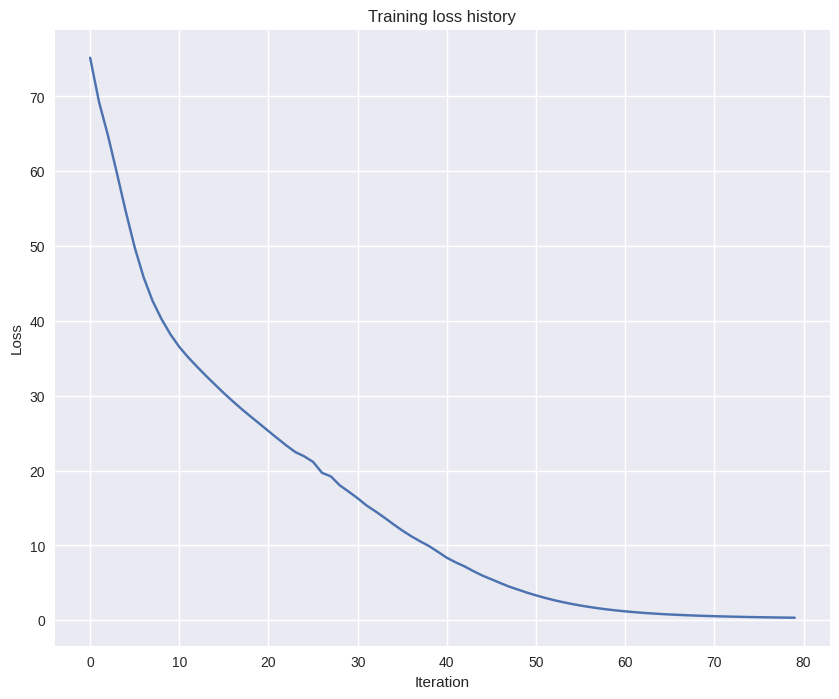

In [14]:
from a5_helper import train_captioner

reset_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train - 1, steps=small_num_train).long()
small_image_data = data_dict["train_images"][sample_idx]
small_caption_data = data_dict["train_captions"][sample_idx]

# optimization arguments
num_epochs = 80

# create the image captioning model
model = CaptioningRNN(
    cell_type="rnn",
    word_to_idx=data_dict["vocab"]["token_to_idx"],
    input_dim=400,  # hard-coded, do not modify
    hidden_dim=512,
    wordvec_dim=256,
    ignore_index=NULL_index,
)
model = model.to(**to_float)

for learning_rate in [1e-3]:
    print("learning rate is: ", learning_rate)
    rnn_overfit, _ = train_captioner(
        model,
        small_image_data,
        small_caption_data,
        num_epochs=num_epochs,
        batch_size=OVR_BATCH_SIZE,
        learning_rate=learning_rate,
        device=DEVICE,
    )

## Inference: Sampling Captions

Unlike classification models, image captioning models behave very differently at training time and at test time.
At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the RNN at each timestep.
At test time, we sample from the distribution over the vocabulary at each timestep, and feed the sample as input to the RNN at the next timestep.

Implement the `CaptioningRNN.sample` for test-time sampling. After doing so, run the following to train a captioning model and sample from the model on both training and validation data.

### Train the image captioning model

Now perform the training on the entire training set. You should see a final loss less than `2.0` and each epoch should take ~6s to run.

For input images in NCHW format, shape (2, 3, 224, 224)
Shape of output c5 features: torch.Size([2, 400, 7, 7])
learning rate is:  0.001
(Epoch 0 / 60) loss: 46.5349 time per epoch: 12.7s
(Epoch 1 / 60) loss: 40.6271 time per epoch: 12.7s
(Epoch 2 / 60) loss: 37.2665 time per epoch: 12.8s
(Epoch 3 / 60) loss: 34.9649 time per epoch: 13.0s
(Epoch 4 / 60) loss: 33.0627 time per epoch: 13.1s
(Epoch 5 / 60) loss: 31.4721 time per epoch: 13.0s
(Epoch 6 / 60) loss: 30.2274 time per epoch: 12.9s
(Epoch 7 / 60) loss: 29.0984 time per epoch: 12.9s
(Epoch 8 / 60) loss: 27.9611 time per epoch: 12.9s
(Epoch 9 / 60) loss: 27.0013 time per epoch: 12.9s
(Epoch 10 / 60) loss: 25.8804 time per epoch: 13.0s
(Epoch 11 / 60) loss: 24.8778 time per epoch: 13.0s
(Epoch 12 / 60) loss: 23.9547 time per epoch: 12.9s
(Epoch 13 / 60) loss: 22.9554 time per epoch: 12.9s
(Epoch 14 / 60) loss: 21.6814 time per epoch: 12.9s
(Epoch 15 / 60) loss: 20.6574 time per epoch: 12.9s
(Epoch 16 / 60) loss: 19.2717 time per ep

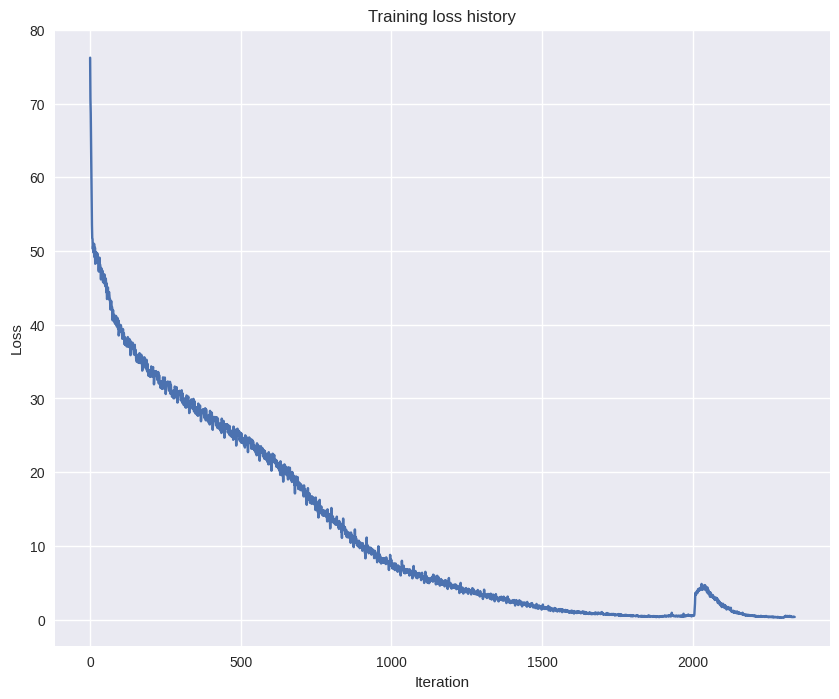

In [15]:
from a5_helper import train_captioner

reset_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,))
small_image_data = data_dict["train_images"][sample_idx]
small_caption_data = data_dict["train_captions"][sample_idx]

# create the image captioning model
rnn_model = CaptioningRNN(
    cell_type="rnn",
    word_to_idx=data_dict["vocab"]["token_to_idx"],
    input_dim=400,  # hard-coded, do not modify
    hidden_dim=512,
    wordvec_dim=256,
    ignore_index=NULL_index,
)

for learning_rate in [1e-3]:
    print("learning rate is: ", learning_rate)
    rnn_model_submit, rnn_loss_submit = train_captioner(
        rnn_model,
        small_image_data,
        small_caption_data,
        num_epochs=60,
        batch_size=BATCH_SIZE,
        learning_rate=learning_rate,
        device=DEVICE,
    )

### Test-time sampling
The samples on training data should be very good; the samples on validation data will probably make less sense.

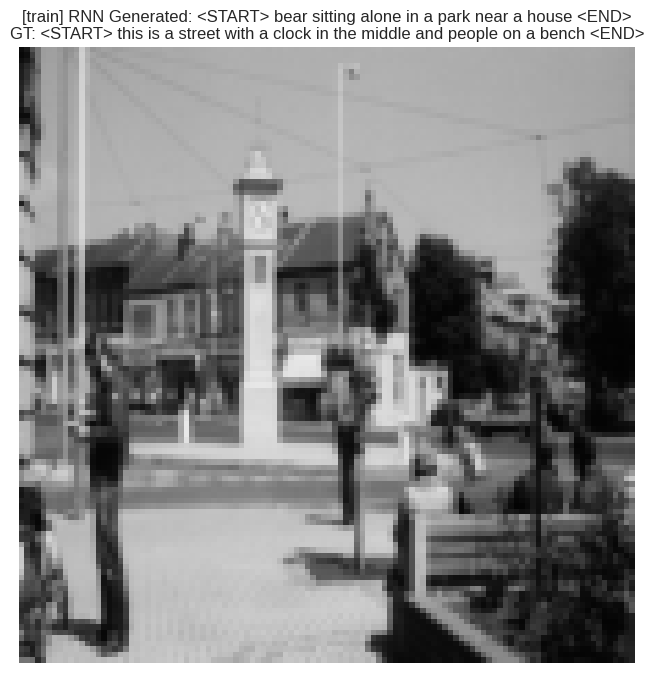

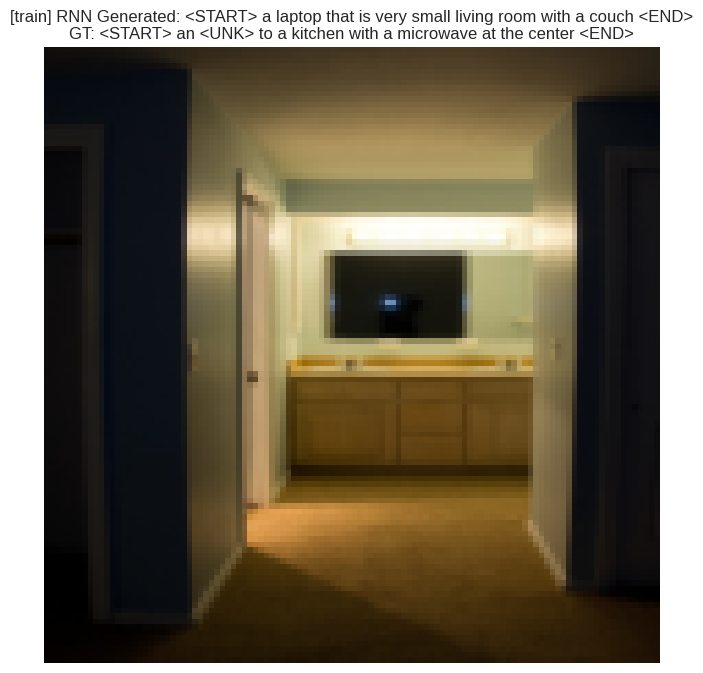

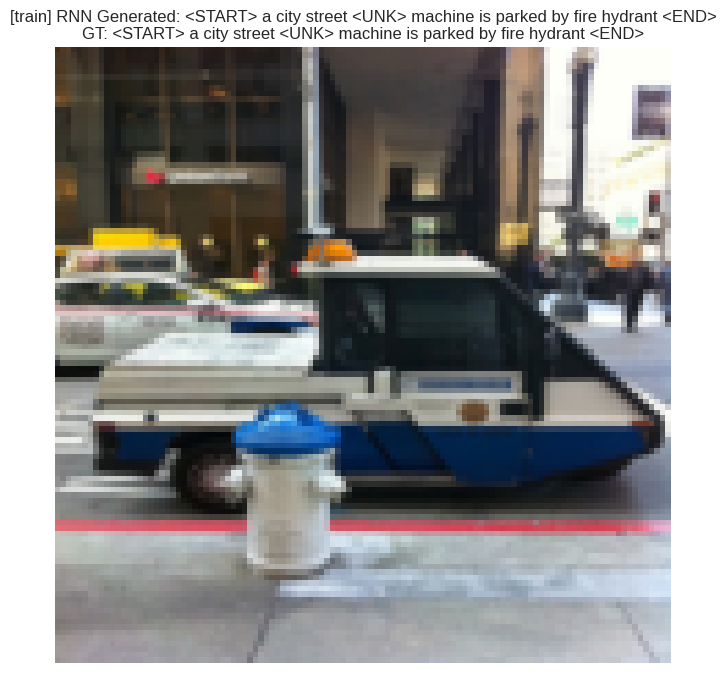

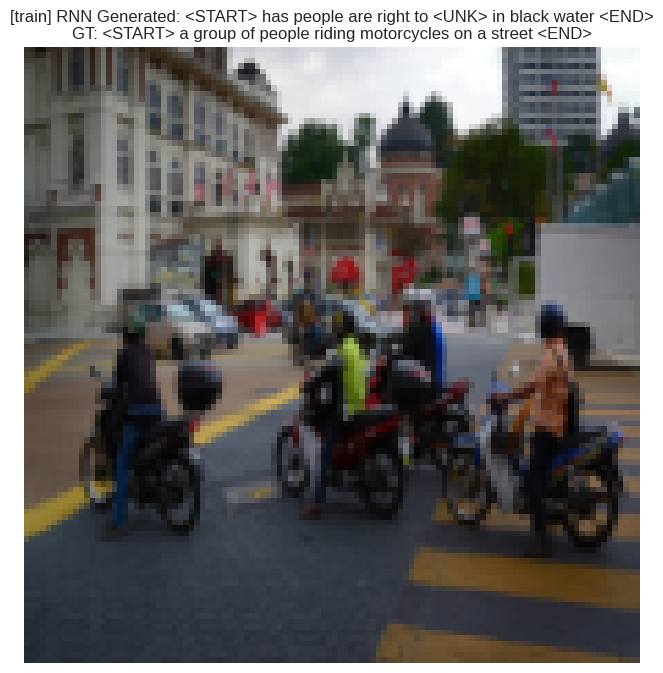

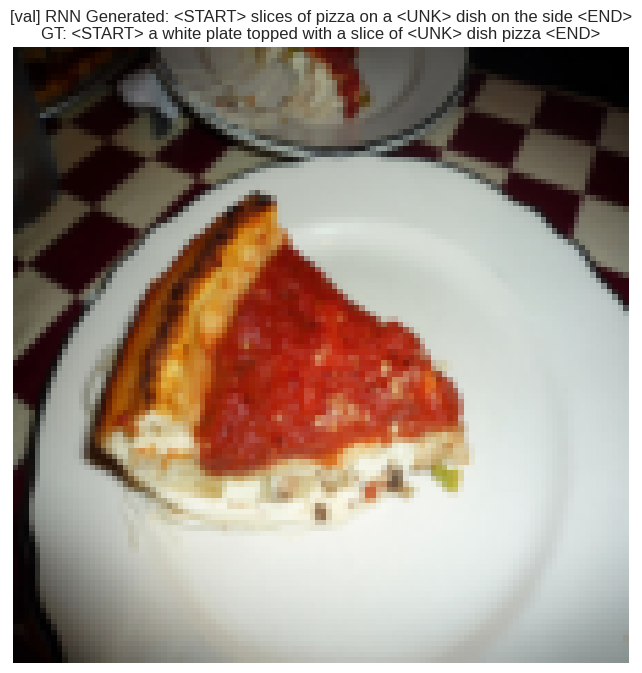

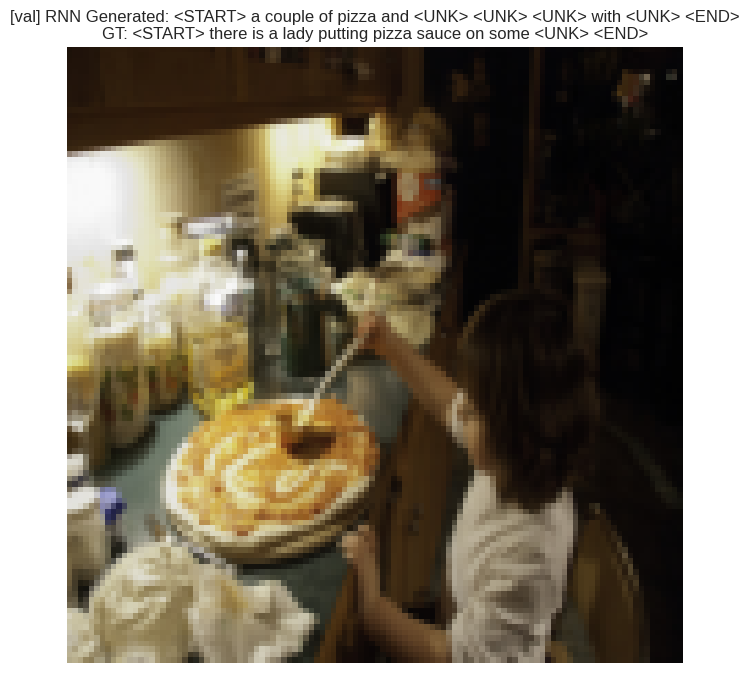

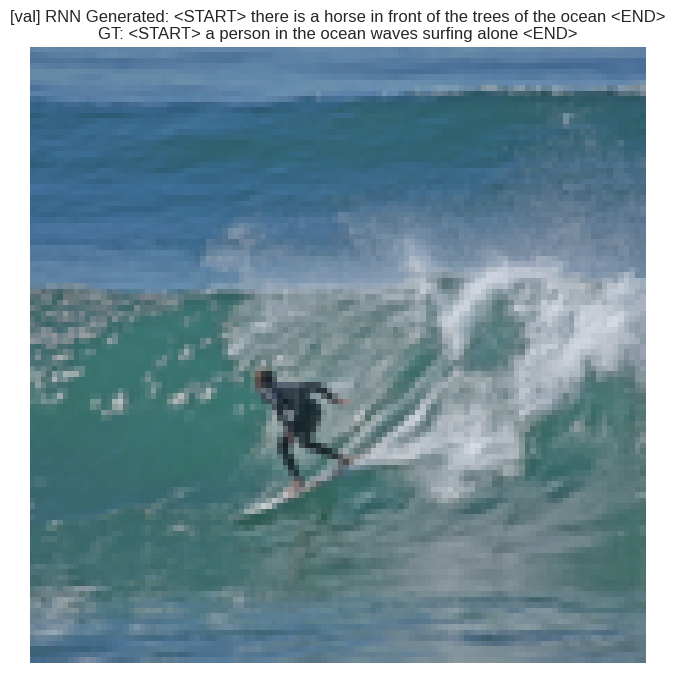

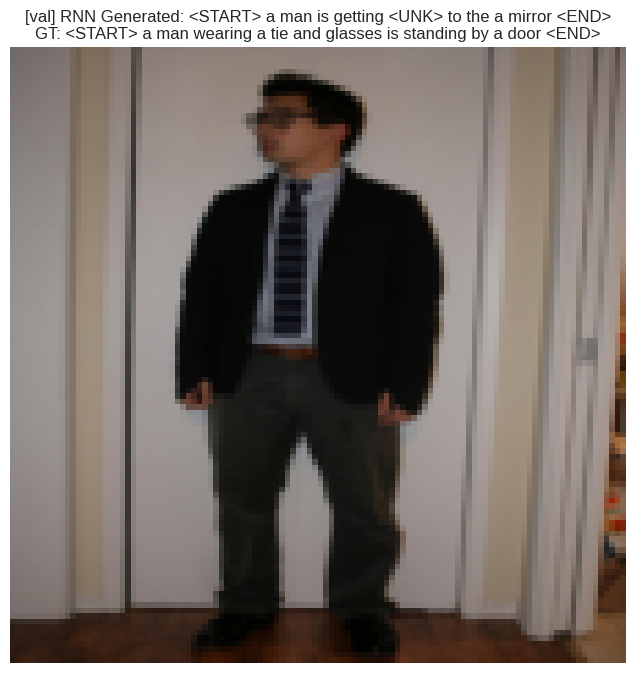

In [16]:
from a5_helper import decode_captions


rnn_model.eval()

for split in ["train", "val"]:
    sample_idx = torch.randint(
        0, num_train if split == "train" else num_val, (VIS_BATCH_SIZE,)
    )
    sample_images = data_dict[split + "_images"][sample_idx]
    sample_captions = data_dict[split + "_captions"][sample_idx]

    # decode_captions is loaded from a5_helper.py
    gt_captions = decode_captions(sample_captions, data_dict["vocab"]["idx_to_token"])

    generated_captions = rnn_model.sample(sample_images.to(DEVICE))
    generated_captions = decode_captions(
        generated_captions, data_dict["vocab"]["idx_to_token"]
    )

    for i in range(VIS_BATCH_SIZE):
        plt.imshow(sample_images[i].permute(1, 2, 0))
        plt.axis("off")
        plt.title(
            f"[{split}] RNN Generated: {generated_captions[i]}\nGT: {gt_captions[i]}"
        )
        plt.show()

# Image Captioning with LSTMs

So far you have implemented a vanilla RNN and applied it to image captioning.
Next we will implement LSTM and use it for image captioning.

**LSTM** stands for [Long-Short Term Memory Networks](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory), a variant of vanilla Recurrent Neural Networks.
Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradients caused by repeated matrix multiplication.
LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism.

**LSTM Update Rule:** Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task.
In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

## LSTM: step forward

Implement the forward pass for a single timestep of an LSTM in the `LSTM.step_forward()` function.
This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.
Since `LSTM` extends PyTorch `nn.Module`, you don't need to implement backward part!

Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `1e-7` or less.

In [17]:
from rnn_lstm_captioning import LSTM


N, D, H = 3, 4, 5
x = torch.linspace(-0.4, 1.2, steps=N * D, **to_double).view(N, D)
prev_h = torch.linspace(-0.3, 0.7, steps=N * H, **to_double).view(N, H)
prev_c = torch.linspace(-0.4, 0.9, steps=N * H, **to_double).view(N, H)
Wx = torch.linspace(-2.1, 1.3, steps=4 * D * H, **to_double).view(D, 4 * H)
Wh = torch.linspace(-0.7, 2.2, steps=4 * H * H, **to_double).view(H, 4 * H)
b = torch.linspace(0.3, 0.7, steps=4 * H, **to_double)


# Create module and copy weight tensors for sanity check:
model = LSTM(D, H).to(**to_double)
model.Wx.data.copy_(Wx)
model.Wh.data.copy_(Wh)
model.b.data.copy_(b)

next_h, next_c = model.step_forward(x, prev_h, prev_c)

expected_next_h = torch.tensor(
    [
        [0.24635157, 0.28610883, 0.32240467, 0.35525807, 0.38474904],
        [0.49223563, 0.55611431, 0.61507696, 0.66844003, 0.7159181],
        [0.56735664, 0.66310127, 0.74419266, 0.80889665, 0.858299],
    ],
    **to_double
)
expected_next_c = torch.tensor(
    [
        [0.32986176, 0.39145139, 0.451556, 0.51014116, 0.56717407],
        [0.66382255, 0.76674007, 0.87195994, 0.97902709, 1.08751345],
        [0.74192008, 0.90592151, 1.07717006, 1.25120233, 1.42395676],
    ],
    **to_double
)

print("next_h error: ", rel_error(expected_next_h, next_h))
print("next_c error: ", rel_error(expected_next_c, next_c))

next_h error:  2.606541143878583e-09
next_c error:  1.7376745523804369e-09


## LSTM: forward

Implement the `LSTM.forward()` function to run an LSTM forward on an entire time-series of data.
When you are done, run the following to check your implementation. You should see an error on the order of `1e-7` or less.

In [18]:
N, D, H, T = 2, 5, 4, 3
x = torch.linspace(-0.4, 0.6, steps=N * T * D, **to_double).view(N, T, D)
h0 = torch.linspace(-0.4, 0.8, steps=N * H, **to_double).view(N, H)
Wx = torch.linspace(-0.2, 0.9, steps=4 * D * H, **to_double).view(D, 4 * H)
Wh = torch.linspace(-0.3, 0.6, steps=4 * H * H, **to_double).view(H, 4 * H)
b = torch.linspace(0.2, 0.7, steps=4 * H, **to_double)


# Create module and copy weight tensors for sanity check:
model = LSTM(D, H).to(**to_double)
model.Wx.data.copy_(Wx)
model.Wh.data.copy_(Wh)
model.b.data.copy_(b)

hn = model(x, h0)

expected_hn = torch.tensor(
    [
        [
            [0.01764008, 0.01823233, 0.01882671, 0.0194232],
            [0.11287491, 0.12146228, 0.13018446, 0.13902939],
            [0.31358768, 0.33338627, 0.35304453, 0.37250975],
        ],
        [
            [0.45767879, 0.4761092, 0.4936887, 0.51041945],
            [0.6704845, 0.69350089, 0.71486014, 0.7346449],
            [0.81733511, 0.83677871, 0.85403753, 0.86935314],
        ],
    ],
    **to_double
)

print("hn error: ", rel_error(expected_hn, hn))

hn error:  2.668523515654886e-09


## LSTM captioning model

Now that you have implemented the `LSTM` module, update the `CaptioningRNN` module (`__init__` and `forward` implementation method **ONLY**) to also handle the case where `self.cell_type` is `lstm`.
**This should require adding less than 5 lines of code.**

Once you have done so, run the following to check your implementation. You should see a difference on the order of `1e-7` or less.

In [19]:
from rnn_lstm_captioning import CaptioningRNN

N, D, W, H = 10, 400, 30, 40
word_to_idx = {"<NULL>": 0, "cat": 2, "dog": 3}
V = len(word_to_idx)
T = 13

# YOUR_TURN: Implement CaptioningRNN for lstm
model = CaptioningRNN(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    hidden_dim=H,
    cell_type="lstm",
    ignore_index=NULL_index,
)

model = model.to(DEVICE)

for k, v in model.named_parameters():
    # print(k, v.shape) # uncomment this to see the weight shape
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).view(*v.shape))

images = torch.linspace(
    -3.0, 3.0, steps=(N * 3 * IMAGE_SHAPE[0] * IMAGE_SHAPE[1]), **to_float
).view(N, 3, *IMAGE_SHAPE)
captions = (torch.arange(N * T) % V).view(N, T)

loss = model(images.to(DEVICE), captions.to(DEVICE))
expected_loss = torch.tensor(146.3161468505)

print("loss: ", loss.item())
print("expected loss: ", expected_loss.item())
print("difference: ", rel_error(loss, expected_loss))

For input images in NCHW format, shape (2, 3, 224, 224)
Shape of output c5 features: torch.Size([2, 400, 7, 7])
loss:  146.316162109375
expected loss:  146.31614685058594
difference:  5.214321112077035e-08


## Overfit small data
We have written this part for you. Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see a final loss less than `4` after 80 epochs and it should run fairly quickly.

For input images in NCHW format, shape (2, 3, 224, 224)
Shape of output c5 features: torch.Size([2, 400, 7, 7])
learning rate is:  0.01
(Epoch 0 / 80) loss: 75.0170 time per epoch: 1.0s
(Epoch 1 / 80) loss: 72.6425 time per epoch: 0.9s
(Epoch 2 / 80) loss: 51.8004 time per epoch: 0.9s
(Epoch 3 / 80) loss: 47.8470 time per epoch: 0.9s
(Epoch 4 / 80) loss: 51.2725 time per epoch: 0.9s
(Epoch 5 / 80) loss: 47.6441 time per epoch: 0.8s
(Epoch 6 / 80) loss: 46.3093 time per epoch: 0.9s
(Epoch 7 / 80) loss: 44.0626 time per epoch: 0.8s
(Epoch 8 / 80) loss: 42.1764 time per epoch: 0.9s
(Epoch 9 / 80) loss: 40.5530 time per epoch: 1.2s
(Epoch 10 / 80) loss: 39.5234 time per epoch: 1.1s
(Epoch 11 / 80) loss: 38.1858 time per epoch: 1.1s
(Epoch 12 / 80) loss: 36.3858 time per epoch: 1.1s
(Epoch 13 / 80) loss: 34.5053 time per epoch: 0.9s
(Epoch 14 / 80) loss: 32.6286 time per epoch: 0.8s
(Epoch 15 / 80) loss: 30.6081 time per epoch: 0.8s
(Epoch 16 / 80) loss: 28.6291 time per epoch: 0.9s
(Epoch 

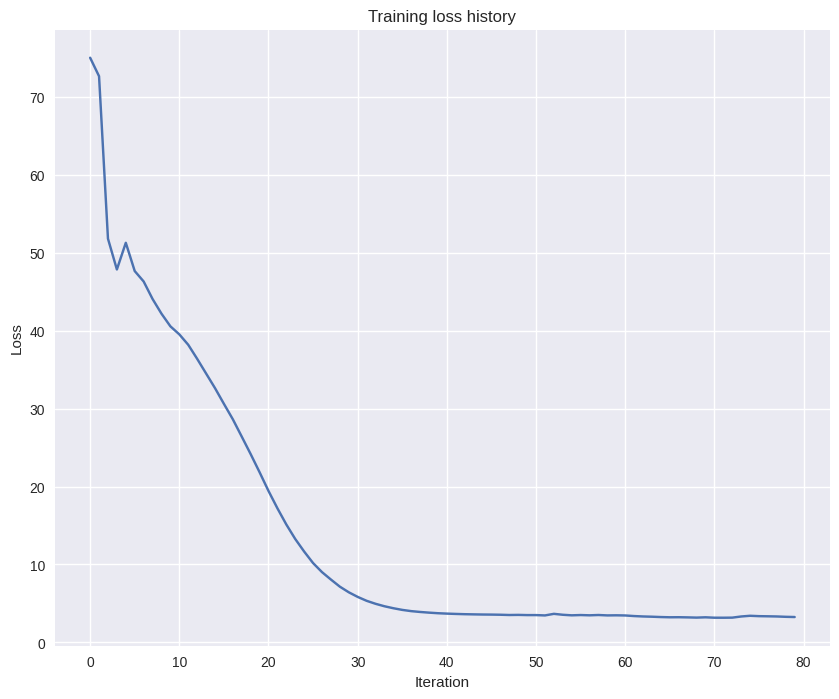

In [20]:
from a5_helper import train_captioner


reset_seed(0)

# Data input.
small_num_train = 50
sample_idx = torch.linspace(0, num_train - 1, steps=small_num_train).long()
small_image_data = data_dict["train_images"][sample_idx].to(DEVICE)
small_caption_data = data_dict["train_captions"][sample_idx].to(DEVICE)

# Create the image captioning model.
model = CaptioningRNN(
    cell_type="lstm",
    word_to_idx=data_dict["vocab"]["token_to_idx"],
    input_dim=400,  # hard-coded, do not modify
    hidden_dim=512,
    wordvec_dim=256,
    ignore_index=NULL_index,
)
model = model.to(DEVICE)

for learning_rate in [1e-2]:
    print("learning rate is: ", learning_rate)
    lstm_overfit, _ = train_captioner(
        model,
        small_image_data,
        small_caption_data,
        num_epochs=80,
        batch_size=OVR_BATCH_SIZE,
        learning_rate=learning_rate,
    )

## Caption sampling

Modify the  `CaptioningRNN.sample` method in class to handle the case where `self.cell_type` is `lstm`. **This should take fewer than 10 lines of code.**
When you are done, run the following cells to train the captioning model first, then sample some captions from your model during test time.

### Train the net

Perform the training on the entire training set. You should see a final loss less than `1.8`. Each epoch should take ~7s to run.

For input images in NCHW format, shape (2, 3, 224, 224)
Shape of output c5 features: torch.Size([2, 400, 7, 7])
learning rate is:  0.001
(Epoch 0 / 60) loss: 47.8016 time per epoch: 13.7s
(Epoch 1 / 60) loss: 42.9347 time per epoch: 13.7s
(Epoch 2 / 60) loss: 38.7603 time per epoch: 13.5s
(Epoch 3 / 60) loss: 36.4952 time per epoch: 13.4s
(Epoch 4 / 60) loss: 34.6832 time per epoch: 13.4s
(Epoch 5 / 60) loss: 33.2821 time per epoch: 13.4s
(Epoch 6 / 60) loss: 31.9096 time per epoch: 13.5s
(Epoch 7 / 60) loss: 30.8548 time per epoch: 13.5s
(Epoch 8 / 60) loss: 29.8076 time per epoch: 13.5s
(Epoch 9 / 60) loss: 28.8666 time per epoch: 13.5s
(Epoch 10 / 60) loss: 28.0798 time per epoch: 13.4s
(Epoch 11 / 60) loss: 27.2051 time per epoch: 13.4s
(Epoch 12 / 60) loss: 26.4002 time per epoch: 13.4s
(Epoch 13 / 60) loss: 25.5733 time per epoch: 13.4s
(Epoch 14 / 60) loss: 24.8096 time per epoch: 13.4s
(Epoch 15 / 60) loss: 24.1250 time per epoch: 13.4s
(Epoch 16 / 60) loss: 23.4538 time per ep

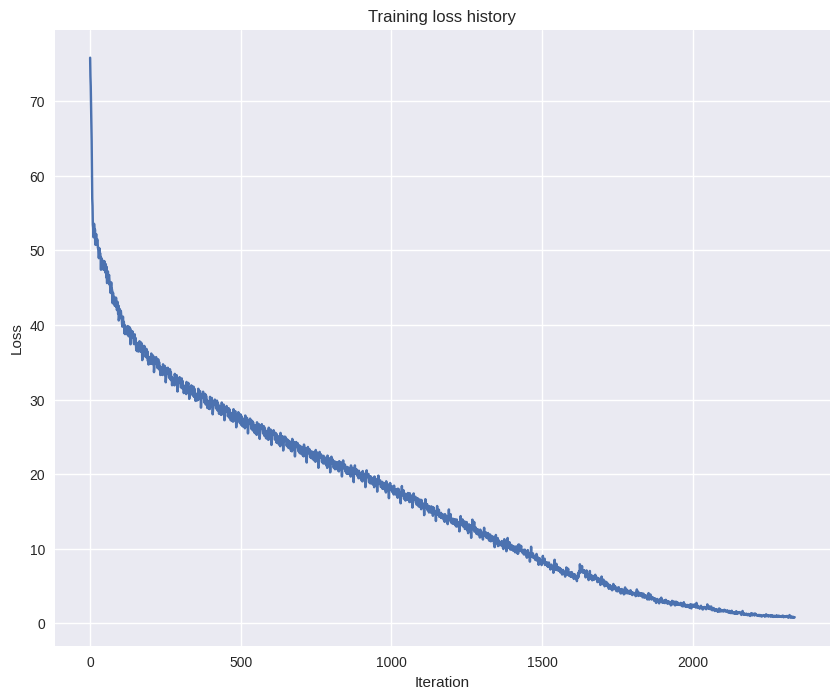

In [21]:
reset_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,))
small_image_data = data_dict["train_images"][sample_idx]
small_caption_data = data_dict["train_captions"][sample_idx]

# create the image captioning model
lstm_model = CaptioningRNN(
    cell_type="lstm",
    word_to_idx=data_dict["vocab"]["token_to_idx"],
    input_dim=400,  # hard-coded, do not modify
    hidden_dim=512,
    wordvec_dim=256,
    ignore_index=NULL_index,
)
lstm_model = lstm_model.to(DEVICE)

for learning_rate in [1e-3]:
    print("learning rate is: ", learning_rate)
    lstm_model_submit, lstm_loss_submit = train_captioner(
        lstm_model,
        small_image_data,
        small_caption_data,
        num_epochs=60,
        batch_size=BATCH_SIZE,
        learning_rate=learning_rate,
        device=DEVICE,
    )

### Test-time sampling
As with the RNN, the samples on training data should be very good; the samples on validation data will probably make less sense.

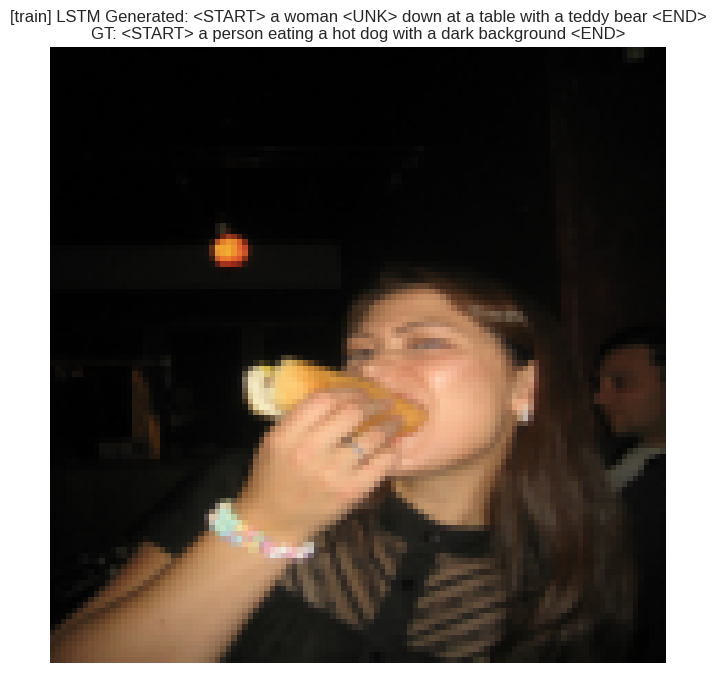

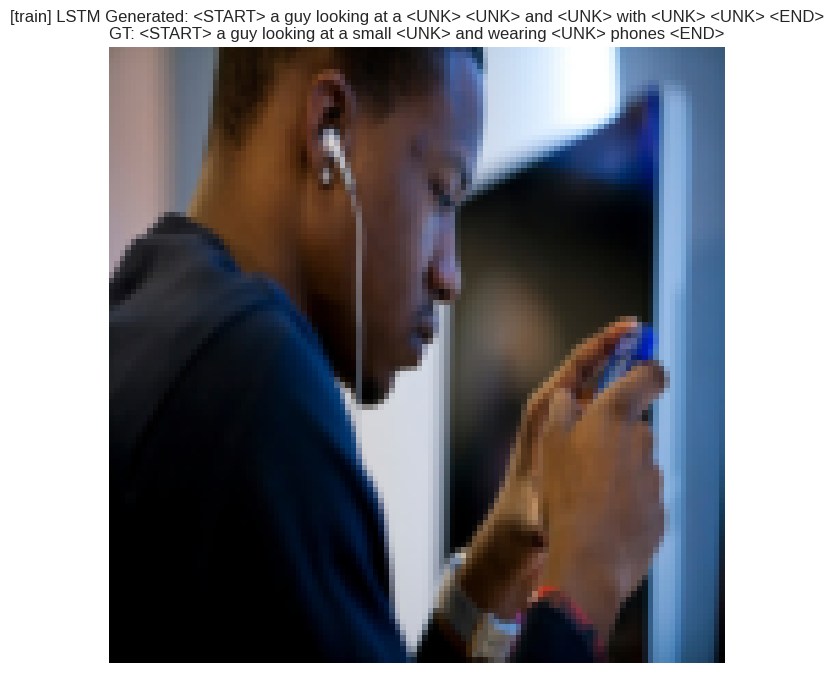

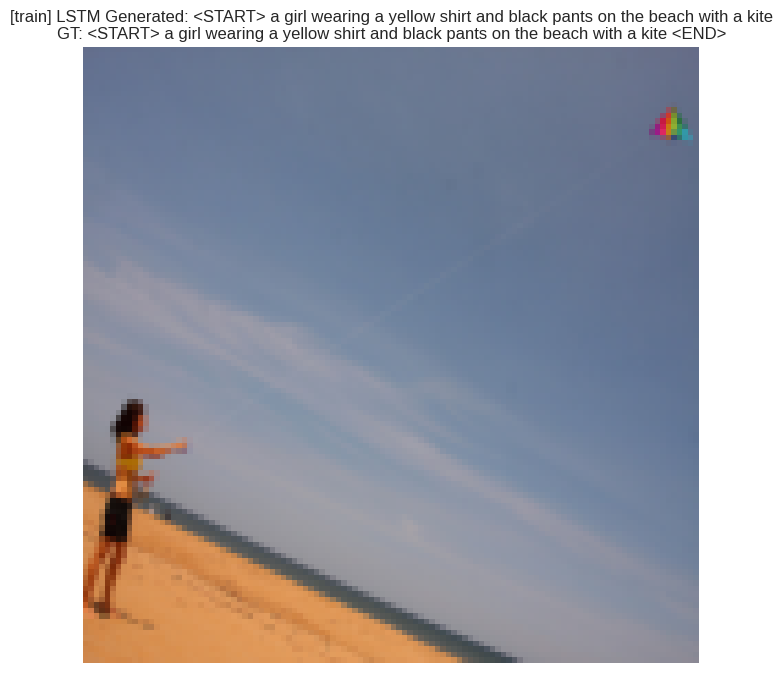

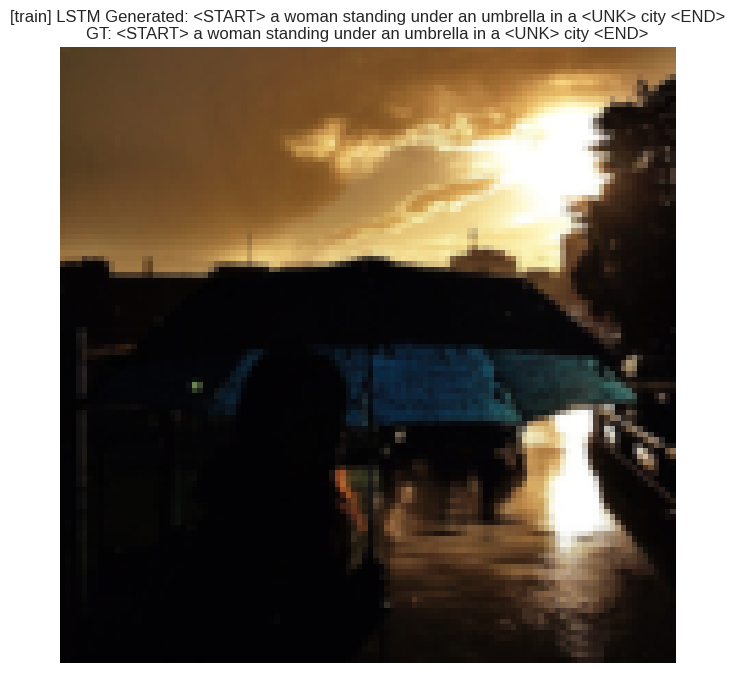

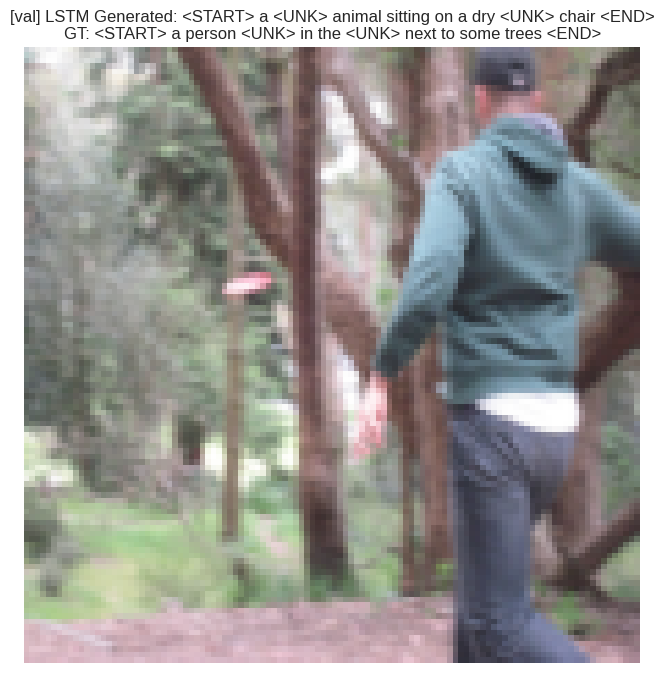

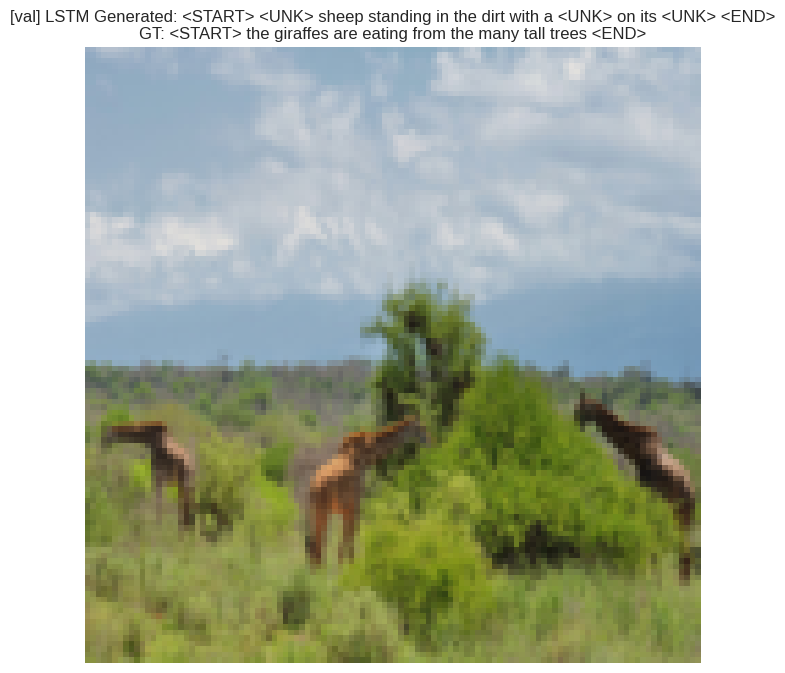

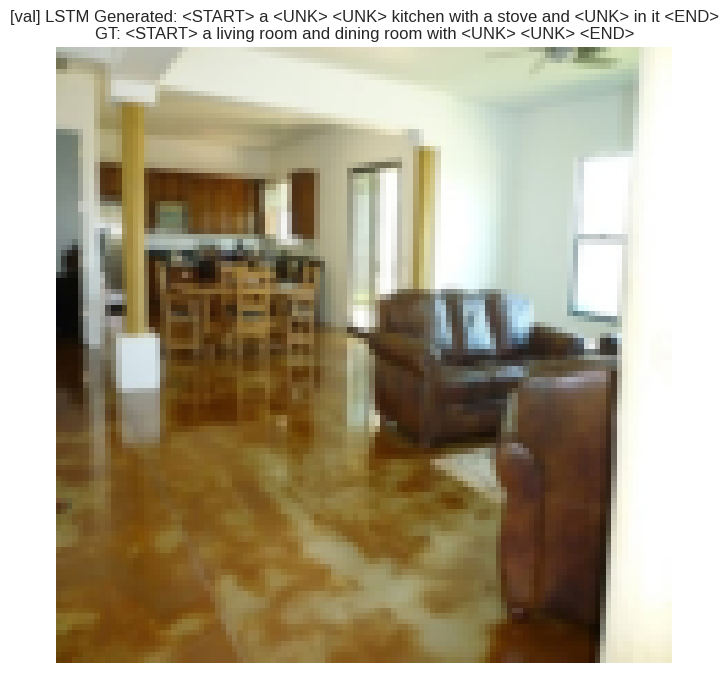

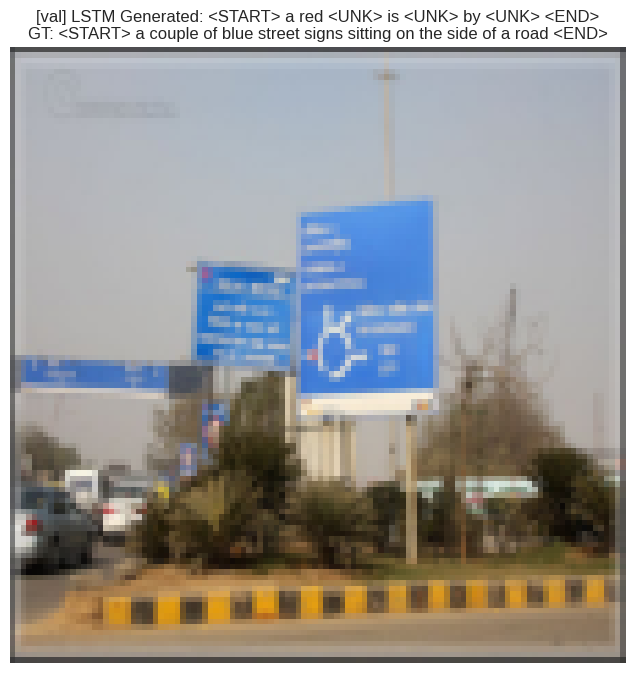

In [22]:
from a5_helper import decode_captions


lstm_model.eval()

for split in ["train", "val"]:
    sample_idx = torch.randint(
        0, num_train if split == "train" else num_val, (VIS_BATCH_SIZE,)
    )
    sample_images = data_dict[split + "_images"][sample_idx]
    sample_captions = data_dict[split + "_captions"][sample_idx]

    # decode_captions is loaded from a5_helper.py
    gt_captions = decode_captions(sample_captions, data_dict["vocab"]["idx_to_token"])
    lstm_model.eval()
    generated_captions = lstm_model.sample(sample_images.to(DEVICE))
    generated_captions = decode_captions(
        generated_captions, data_dict["vocab"]["idx_to_token"]
    )

    for i in range(VIS_BATCH_SIZE):
        plt.imshow(sample_images[i].permute(1, 2, 0))
        plt.axis("off")
        plt.title(
            f"[{split}] LSTM Generated: {generated_captions[i]}\nGT: {gt_captions[i]}"
        )
        plt.show()